### Importing required libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Data Loading

### 1.1 Loading CSV file

In [194]:
boom_bikes_data = pd.read_csv('./datasets/day.csv')

## 2. Data Exploration

### 2.1 Display the first few rows of the DataFrame

In [195]:
boom_bikes_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### 2.2 Get information about the DataFrame

In [196]:
boom_bikes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### 2.3 Understanding Data fields

In [197]:
# converting 'dteday' to date format
boom_bikes_data['dteday'] = pd.to_datetime(boom_bikes_data['dteday'], format="%d-%m-%Y")

In [198]:
# checking if all the 'weekday' values are in accordance with 'dteday' values
(boom_bikes_data['weekday'] == boom_bikes_data['dteday'].dt.dayofweek).sum() == len(boom_bikes_data)

False

In [199]:
# creating new dataframe for comparing 'weekday' values which are not matching with 'dteday' values
week_day_df = boom_bikes_data.loc[:, ['dteday', 'weekday']]

# creating new column 'dayofweek' for comparing with 'weekday'
week_day_df['dayofweek'] = week_day_df['dteday'].dt.dayofweek

# the days for which weekday is not matching with dteday weekday(dayofweek)
week_day_df[~(week_day_df['weekday'] == week_day_df['dayofweek'])][['dteday', 'weekday', 'dayofweek']]

,dteday,weekday,dayofweek
0,2018-01-01,6,0
1,2018-01-02,0,1
2,2018-01-03,1,2
3,2018-01-04,2,3
4,2018-01-05,3,4
...,...,...,...
419,2019-02-24,5,6
420,2019-02-25,6,0
421,2019-02-26,0,1
422,2019-02-27,1,2


In [200]:
del week_day_df

#### After analyzing `dteday dayofweek` and `weekday`
- 0 - Monday
- 1 - Tuesday
- 2 - Wednesday
- 3 - Thursday
- 4 - Friday
- 5 - Saturday
- 6 - Sunday
<br />
Observed anomaly till the date '28-02-2019'. For all the dates before 1st March 2019, the weekday is recorded one day before.

## 3. Data Manipulation

### 3.1 Imputing `weekday` from `dteday`

In [201]:
boom_bikes_data['weekday'] = boom_bikes_data['dteday'].dt.day_name().apply(lambda x:x[:3].lower())

In [202]:
boom_bikes_data[['dteday', 'weekday']]

,dteday,weekday
0,2018-01-01,mon
1,2018-01-02,tue
2,2018-01-03,wed
3,2018-01-04,thu
4,2018-01-05,fri
...,...,...
725,2019-12-27,fri
726,2019-12-28,sat
727,2019-12-29,sun
728,2019-12-30,mon


In [203]:
# checking if any of the 'dteday' column values are duplicated
boom_bikes_data['dteday'].duplicated().any()

False

In [204]:
# considering year as categorical variable to observe the trends over 2018 and 2019
boom_bikes_data['yr'] = boom_bikes_data['yr'].map({0:2018, 1:2019})

In [205]:
# checking if 'yr' column values are matching with 'dteday' column year values
(boom_bikes_data['yr'] == boom_bikes_data['dteday'].dt.year).sum() == len(boom_bikes_data)

True

In [206]:
# checking if 'mnth' column values are matching with 'dteday' column month values
(boom_bikes_data['mnth'] == boom_bikes_data['dteday'].dt.month).sum() == len(boom_bikes_data)

True

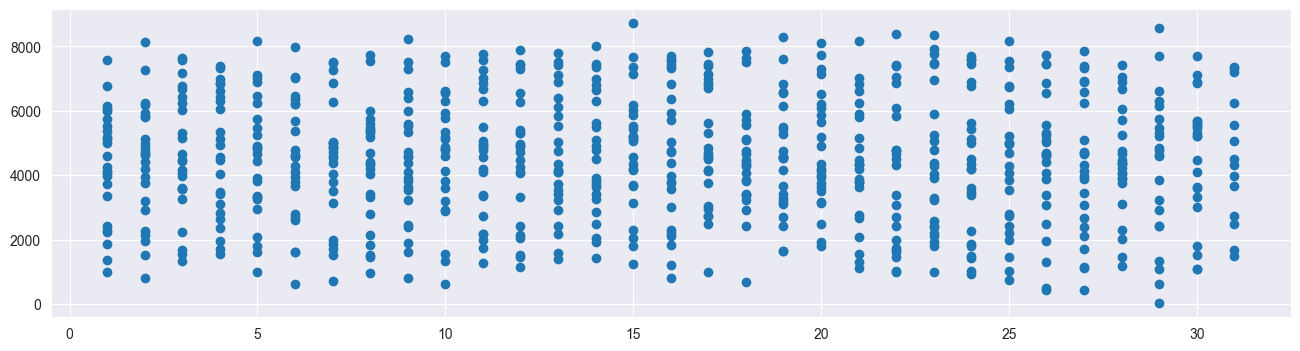

In [207]:
# checking if any useful insights can be drawn from 'dteday' column day field
plt.figure(figsize=(16, 4))
plt.scatter(boom_bikes_data['dteday'].dt.day, boom_bikes_data['cnt'])
plt.show()

### 3.2 Dropping extra columns
- __instant__: It is just index column.
- __dteday__: It is the date column, and we already have month, yr and weekday columns. The scatter plot of dates vs cnt doesn't follow any pattern and hence irrelavant.
- __casual & registered__: As the total count is already available in `cnt` column, we can drop casual and registered columns

In [208]:
boom_bikes_data.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

### 3.3 Mapping values from data dictionary

In [209]:
boom_bikes_data['season'] = boom_bikes_data['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

In [210]:
boom_bikes_data['mnth'] = boom_bikes_data['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [211]:
boom_bikes_data['weathersit'] = boom_bikes_data['weathersit'].map({1:'clear_or_light_clouds',2:'mist_or_light_clouds',3:'light_snow_or_rain',4:'heavy_snow_or_rain'})

In [212]:
boom_bikes_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,mon,0,mist_or_light_clouds,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,tue,0,mist_or_light_clouds,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,wed,1,clear_or_light_clouds,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,thu,1,clear_or_light_clouds,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,fri,1,clear_or_light_clouds,9.305237,11.46350,43.6957,12.522300,1600


In [213]:
boom_bikes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


## 4. Univariate Analysis

### 4.1 Numerical columns

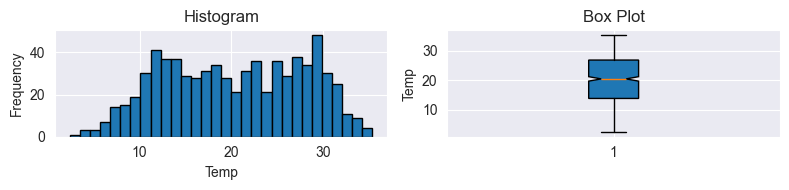

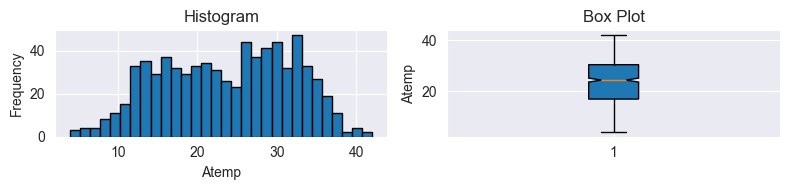

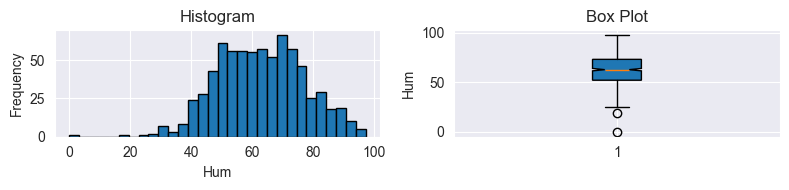

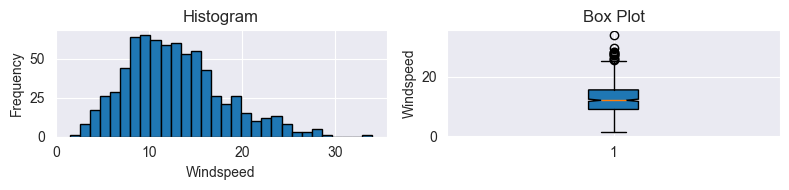

Temp => 1st quartile: 13.8,  median: 20.5, 3rd quartile: 26.9
Atemp => 1st quartile: 16.9,  median: 24.4, 3rd quartile: 30.4
Hum => 1st quartile: 52.0,  median: 62.6, 3rd quartile: 73.0
Windspeed => 1st quartile: 9.0,  median: 12.1, 3rd quartile: 15.6


In [214]:
num_cols = ['temp', 'atemp', 'hum', 'windspeed']

for col in num_cols:
    data = boom_bikes_data[col]
    col_name = col.replace('_', ' ').title()
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))

    # Plotting histogram
    axs[0].hist(data, bins=30, edgecolor='black')
    axs[0].set_title('Histogram')
    axs[0].set_xlabel(col_name)
    axs[0].set_ylabel('Frequency')

    # Plotting box plot
    axs[1].boxplot(data, patch_artist=True, notch=True)
    axs[1].set_title('Box Plot')
    axs[1].set_ylabel(col_name)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

for col in num_cols:
    data = boom_bikes_data[col]
    print('{} => 1st quartile: {},  median: {}, 3rd quartile: {}'.format(
        col.title(), round(np.percentile(data, 25), 1), round(data.median(), 1), round(np.percentile(data, 75), 1)))

### Observations:
- __temp__: Temparature is mostly ranging in the region of 13.8 to 26.9 degrees with median of 20.5 degrees
- __atemp__: This field is mostly ranging from 16.9 to 30.4 degress with median of 24.4 degress
- __hum__: Humidity is in the range of 52 to 73 units mostly with median of 62.6 units
- __windspeed__: Windspeed is in the range of 9 to 12.1 units mostly with median of 12.1 units

### 4.2 Categorical columns

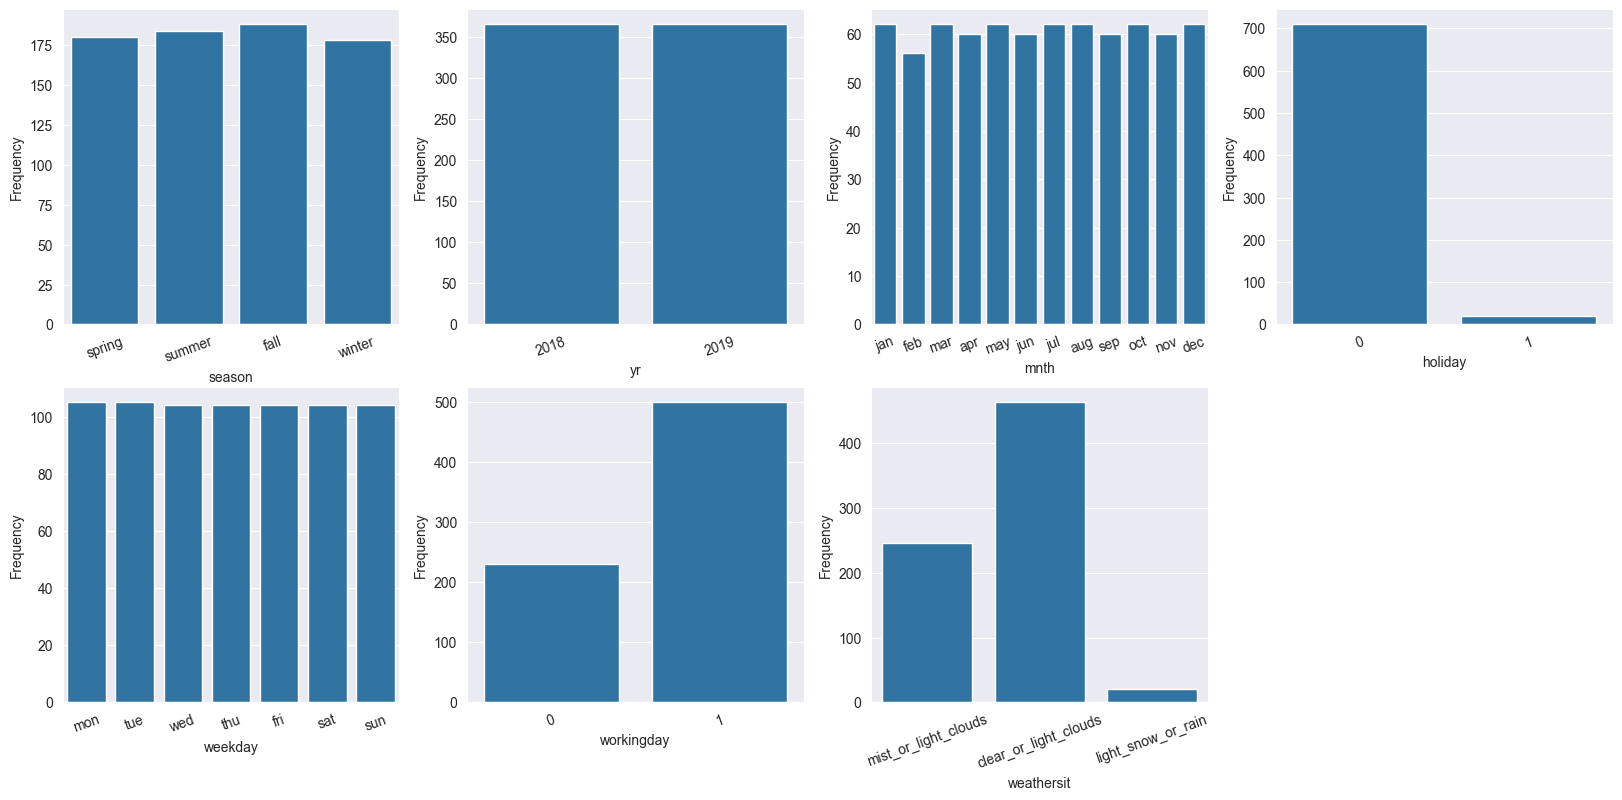

In [215]:
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

plt.figure(figsize=(20, 9))
for count, col in enumerate(cat_cols):
    plt.subplot(2, 4, count+1)
    sns.countplot(x=boom_bikes_data[col])
    plt.xticks(rotation=20)
    plt.ylabel('Frequency')
plt.show()

### Observations:
- __season__: Fall has higher number of days when compared with other seasons.
- __yr__: Both are non-leap years and have same no. of days.
- __mnth__: February has the least number of days than any other month.
- __holiday__: No. of holidays in a year are always less.
- __weekday__: Every week day almost occur same no. of times in a year.
- __workingday__: No. of non-working days are almost 32% of the years 2018 and 2019 combined.
- __weathersit__: Most of the days in the period 2018 and 2019 are clear or with light clouds. There are very less snow or rainy days.

## 5. Bi-variate Analysis

### 5.1 Numerical columns vs `cnt`

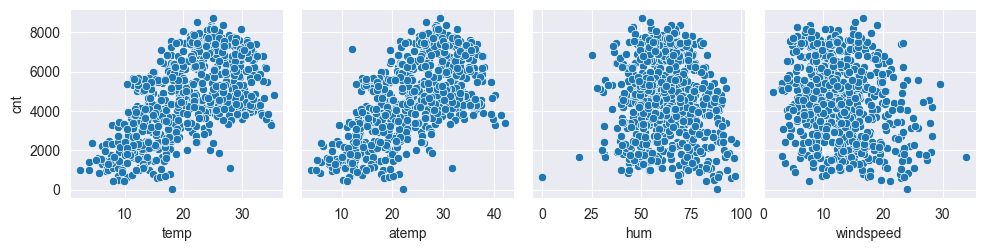

In [216]:
sns.pairplot(boom_bikes_data, x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars='cnt', kind='scatter')
plt.show()

### Observations:
- Both `temp` and `atemp` variables are having almost same distribution. These columns appear to follow some linear relation with bike booking count.
- The variables `hum` and `windspeed` does not appear to be in linear relation with bike booking count.

### 5.2 Categorical columns vs `cnt`

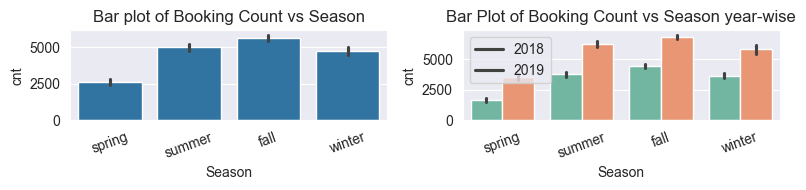

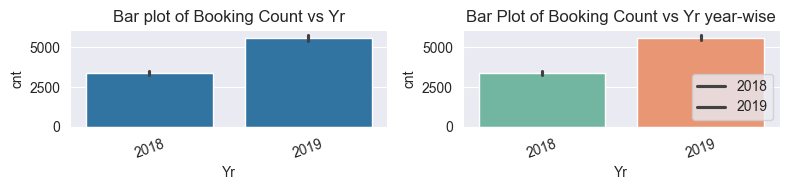

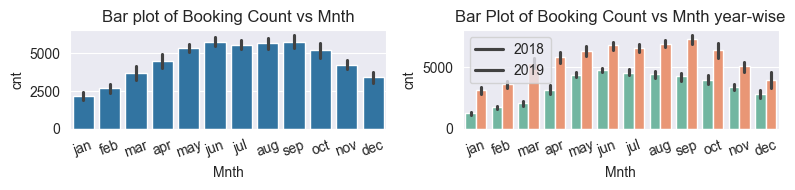

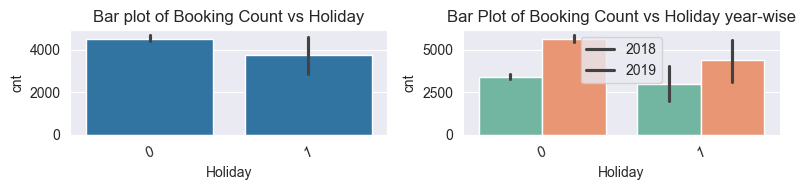

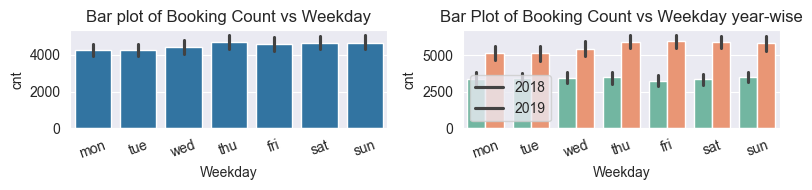

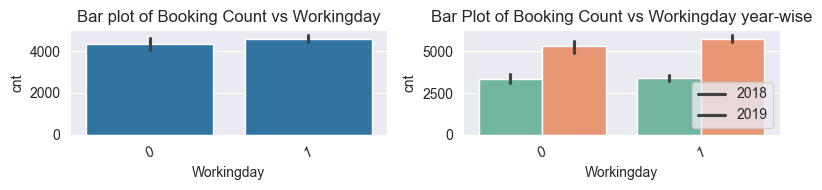

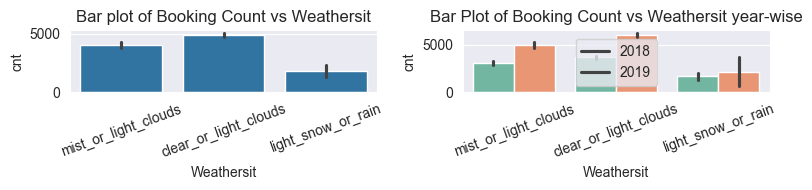

In [217]:
# visualising categorical variables
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

for col in cat_cols:
    col_name = col.replace('_', ' ').title()
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))

    sns.barplot(x=boom_bikes_data[col], y=boom_bikes_data['cnt'], ax=axs[0])
    axs[0].set_title('Bar plot of Booking Count vs '+col_name)
    axs[0].set_xlabel(col_name)
    axs[0].set_ylabel('cnt')
    axs[0].tick_params(axis='x', rotation=20)

    sns.barplot(x=boom_bikes_data[col], y=boom_bikes_data['cnt'], ax=axs[1], hue=boom_bikes_data['yr'], palette='Set2')
    axs[1].set_title('Bar Plot of Booking Count vs '+col_name+' year-wise')
    axs[1].set_xlabel(col_name)
    axs[1].set_ylabel('cnt')
    axs[1].tick_params(axis='x', rotation=20)
    axs[1].legend(labels=['2018', '2019'])

    plt.tight_layout()
    plt.show()

### Observations:
- __season__: More no. of bookings happened in Fall and least no. of bookings in Spring.
- __yr__: More bookings happened in 2019 than in 2018, probably due to increase in the popularity of Boom Bikes.
- __mnth__: The bookings are more starting from June till September in both the years.
- __holiday__: Bookings in holidays are less.
- __weekday__: Booking count is not varying much based on weekday.
- __workingday__: Bookings are slightly higher on working days.
- __weathersit__: More bookings happened on clear sky or partly cloudy days and fewer bookings happened on light snow or rainy days.

## 6. Creation of Dummy Variables for categorical variables

### 6.1 Categories count in each categorical column

In [218]:
for col in cat_cols:
    print('{}: {}'.format(col, len(boom_bikes_data[col].value_counts())))

season: 4
yr: 2
mnth: 12
holiday: 2
weekday: 7
workingday: 2
weathersit: 3


### 6.2 Creation of Dummy variable for columns where categories are more than 2

In [219]:
seasons_df=pd.get_dummies(boom_bikes_data['season'],drop_first=True, dtype=int)
months_df=pd.get_dummies(boom_bikes_data['mnth'],drop_first=True, dtype=int)
weekdays_df=pd.get_dummies(boom_bikes_data['weekday'],drop_first=True, dtype=int)
weathersit_df=pd.get_dummies(boom_bikes_data['weathersit'],drop_first=True, dtype=int)

### 6.3 Merging the dataframe with dummy variable datasets

In [220]:
boom_bikes_data_with_dummies = pd.concat([boom_bikes_data, seasons_df, months_df, weekdays_df, weathersit_df],axis=1)
boom_bikes_data_with_dummies.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,oct,sep,mon,sat,sun,thu,tue,wed,light_snow_or_rain,mist_or_light_clouds
0,spring,2018,jan,0,mon,0,mist_or_light_clouds,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,0,1
1,spring,2018,jan,0,tue,0,mist_or_light_clouds,14.902598,17.68695,69.6087,...,0,0,0,0,0,0,1,0,0,1
2,spring,2018,jan,0,wed,1,clear_or_light_clouds,8.050924,9.47025,43.7273,...,0,0,0,0,0,0,0,1,0,0
3,spring,2018,jan,0,thu,1,clear_or_light_clouds,8.200000,10.60610,59.0435,...,0,0,0,0,0,1,0,0,0,0
4,spring,2018,jan,0,fri,1,clear_or_light_clouds,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,0,0,0


In [221]:
boom_bikes_data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                730 non-null    object 
 1   yr                    730 non-null    int64  
 2   mnth                  730 non-null    object 
 3   holiday               730 non-null    int64  
 4   weekday               730 non-null    object 
 5   workingday            730 non-null    int64  
 6   weathersit            730 non-null    object 
 7   temp                  730 non-null    float64
 8   atemp                 730 non-null    float64
 9   hum                   730 non-null    float64
 10  windspeed             730 non-null    float64
 11  cnt                   730 non-null    int64  
 12  spring                730 non-null    int64  
 13  summer                730 non-null    int64  
 14  winter                730 non-null    int64  
 15  aug                   7

In [222]:
# dropping unnecessary columns as we have already created dummy variable out of it.
boom_bikes_data_with_dummies.drop(columns=['season', 'mnth', 'weekday', 'weathersit'], inplace = True)

## 7. Splitting Train and Test data

In [223]:
df_train, df_test = train_test_split(boom_bikes_data_with_dummies, train_size = 0.7, random_state = 100)

In [224]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


In [225]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,mon,sat,sun,thu,tue,wed,light_snow_or_rain,mist_or_light_clouds
576,2019,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,...,0,0,0,0,0,0,0,1,0,0
426,2019,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,...,0,0,0,0,1,0,0,0,0,1
728,2019,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,...,0,0,1,0,0,0,0,0,0,0
482,2019,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,...,0,0,0,0,1,0,0,0,0,1
111,2018,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,1,...,0,0,0,0,1,0,0,0,0,1


In [226]:
# Using MinMaxScaler to Rescaling the features
scaler = MinMaxScaler()

In [227]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables

num_vars = ['yr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [228]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,mon,sat,sun,thu,tue,wed,light_snow_or_rain,mist_or_light_clouds
576,1.0,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1.0,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,1,0,0,0,0,1
728,1.0,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,1,0,0,0,0,0,0,0
482,1.0,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,1,0,0,0,0,1
111,0.0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,1,0,0,0,0,1


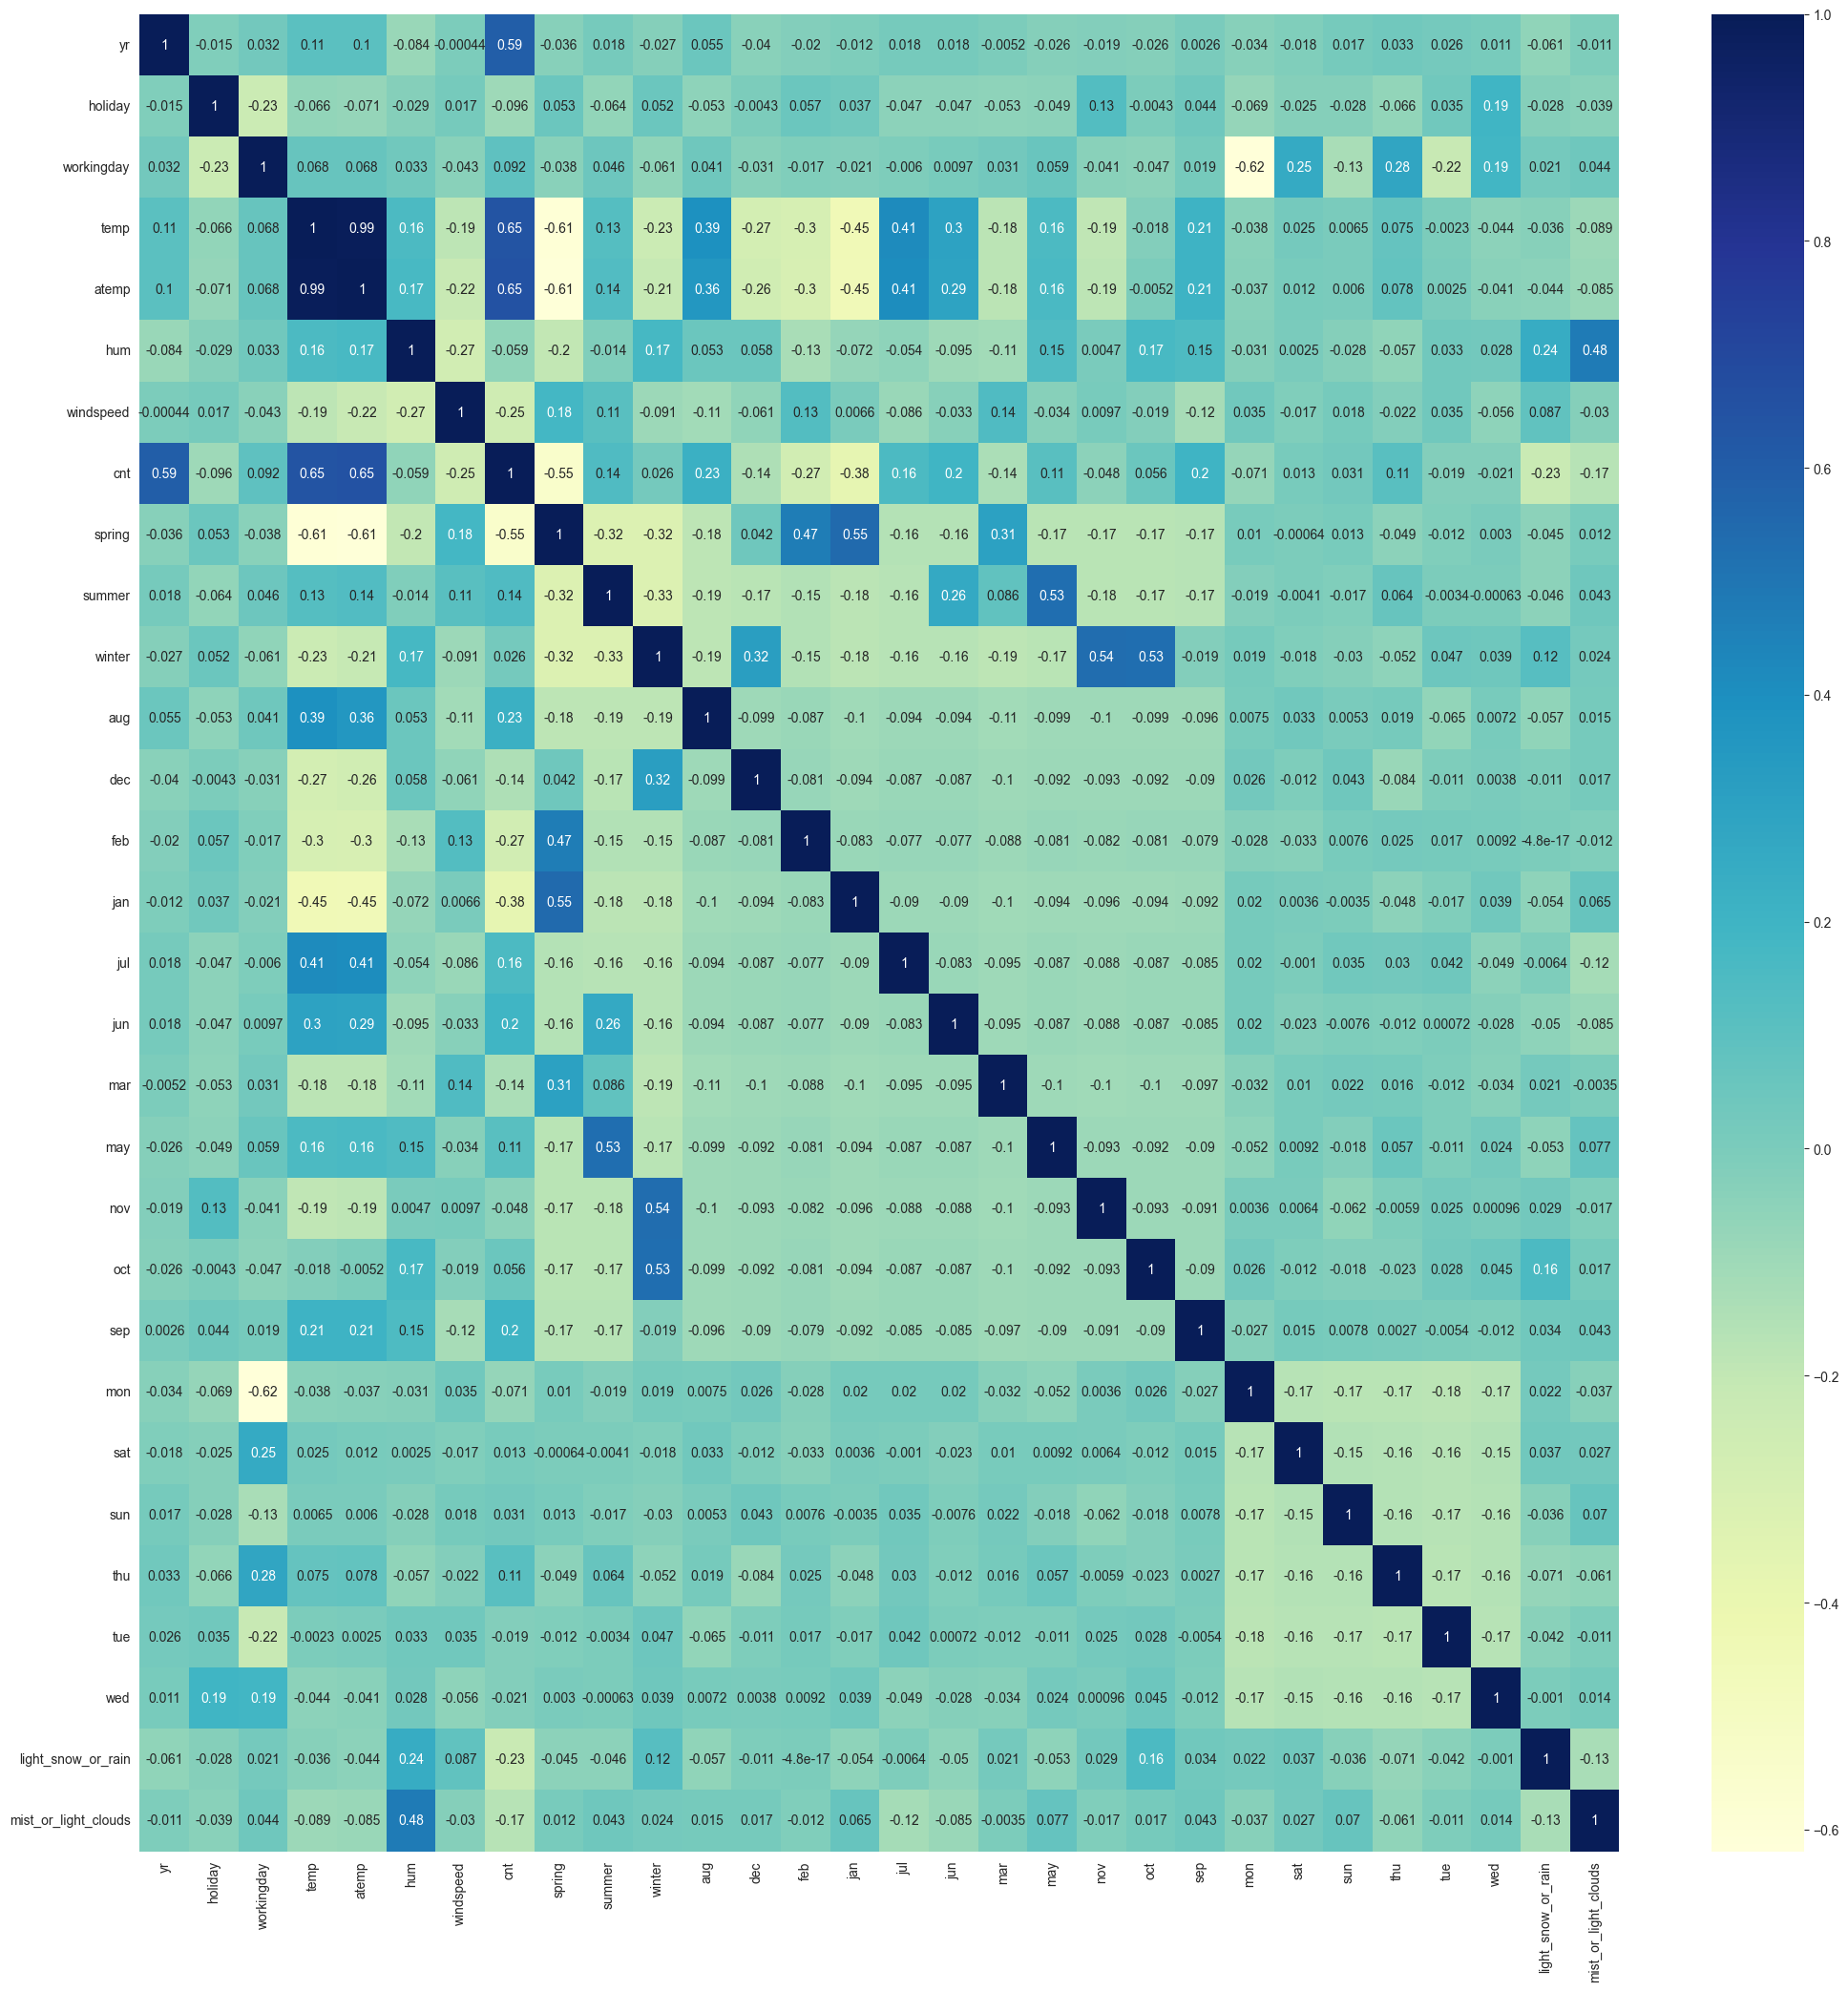

In [229]:
# heatmap
plt.figure(figsize = (25, 25))
sns.heatmap(df_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

## 8. Building the Linear Model

In [230]:
y_train = df_train.pop('cnt')
X_train = df_train

### 8.1 Recursive Feature Elimination (RFE)

In [231]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [232]:
# list of variables selected in top 15 list
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 15),
 ('temp', True, 1),
 ('atemp', False, 3),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 7),
 ('dec', True, 1),
 ('feb', False, 2),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 9),
 ('mar', False, 14),
 ('may', False, 6),
 ('nov', True, 1),
 ('oct', False, 11),
 ('sep', True, 1),
 ('mon', False, 5),
 ('sat', False, 13),
 ('sun', False, 10),
 ('thu', False, 12),
 ('tue', False, 4),
 ('wed', False, 8),
 ('light_snow_or_rain', True, 1),
 ('mist_or_light_clouds', True, 1)]

In [233]:
# selecting the selected variable via RFE in col list
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'dec', 'jan', 'jul', 'nov', 'sep', 'light_snow_or_rain',
       'mist_or_light_clouds'],
      dtype='object')

In [234]:
# checking which columns has been rejected
X_train.columns[~rfe.support_]

Index(['workingday', 'atemp', 'aug', 'feb', 'jun', 'mar', 'may', 'oct', 'mon',
       'sat', 'sun', 'thu', 'tue', 'wed'],
      dtype='object')

### 8.2 Create X_train_new dataframe with RFE selected variables

In [235]:
X_train_new = X_train[col]

### 8.3 Manual Feature Selection

In [236]:
# Adding a constant variable
X_train_lm = sm.add_constant(X_train_new)

In [237]:
lm = sm.OLS(y_train, X_train_lm).fit() # running the linear model

In [238]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          8.15e-189
Time:                        14:50:23   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3197 

In [239]:
# function to calculate VIF of variables
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [240]:
# calculate VIF
calculate_vif(X_train_new)

,Features,VIF
3,hum,30.89
2,temp,17.79
4,windspeed,4.72
5,spring,4.37
7,winter,4.06
6,summer,2.82
14,mist_or_light_clouds,2.32
0,yr,2.09
11,nov,1.85
9,jan,1.75


### 8.3.1 Dropping `hum` as it has high VIF and running the model again

In [241]:
X_train_new = X_train_new.drop(columns = 'hum')
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     184.5
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          4.75e-186
Time:                        14:50:23   Log-Likelihood:                 504.85
No. Observations:                 510   AIC:                            -979.7
Df Residuals:                     495   BIC:                            -916.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2450 

In [242]:
calculate_vif(X_train_new)

,Features,VIF
2,temp,5.17
3,windspeed,4.67
6,winter,2.95
4,spring,2.89
5,summer,2.24
0,yr,2.07
10,nov,1.81
8,jan,1.66
9,jul,1.59
13,mist_or_light_clouds,1.57


### 8.3.2 Dropping `temp` as it has high VIF and running the model again

In [243]:
X_train_new = X_train_new.drop(columns='temp')
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     144.9
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          1.82e-159
Time:                        14:50:24   Log-Likelihood:                 438.84
No. Observations:                 510   AIC:                            -849.7
Df Residuals:                     496   BIC:                            -790.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5954 

In [244]:
calculate_vif(X_train_new)

,Features,VIF
2,windspeed,3.89
3,spring,2.89
5,winter,2.85
4,summer,2.02
0,yr,1.83
9,nov,1.80
7,jan,1.64
12,mist_or_light_clouds,1.53
6,dec,1.46
8,jul,1.20


### 8.3.3 Dropping `jul` as it has high p-value and running the model again

In [245]:
X_train_new = X_train_new.drop(columns=['jul'])
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     157.0
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          2.08e-160
Time:                        14:50:24   Log-Likelihood:                 438.45
No. Observations:                 510   AIC:                            -850.9
Df Residuals:                     497   BIC:                            -795.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5886 

In [246]:
calculate_vif(X_train_new)

,Features,VIF
2,windspeed,3.52
5,winter,2.75
3,spring,2.71
4,summer,1.87
8,nov,1.80
0,yr,1.77
7,jan,1.64
11,mist_or_light_clouds,1.52
6,dec,1.46
9,sep,1.16


### 8.3.4 Dropping `winter` as it has high p-value and running the model again

In [247]:
X_train_new = X_train_new.drop(columns=['winter'])
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     171.2
Date:                Sat, 20 Apr 2024   Prob (F-statistic):          2.71e-161
Time:                        14:50:24   Log-Likelihood:                 437.88
No. Observations:                 510   AIC:                            -851.8
Df Residuals:                     498   BIC:                            -800.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5834 

In [248]:
calculate_vif(X_train_new)

,Features,VIF
2,windspeed,3.23
3,spring,2.37
0,yr,1.74
4,summer,1.70
6,jan,1.62
10,mist_or_light_clouds,1.48
7,nov,1.23
8,sep,1.16
5,dec,1.13
9,light_snow_or_rain,1.07


In [249]:
X_train_new.columns

Index(['yr', 'holiday', 'windspeed', 'spring', 'summer', 'dec', 'jan', 'nov',
       'sep', 'light_snow_or_rain', 'mist_or_light_clouds'],
      dtype='object')

## 9. Residual Analysis

In [250]:
y_train_pred = lm.predict(X_train_lm)
y_train_pred

576    0.778775
426    0.456710
728    0.349454
482    0.668760
111    0.386045
         ...   
578    0.793589
53     0.325474
350    0.297159
79     0.357598
520    0.636067
Length: 510, dtype: float64

In [251]:
res = y_train - y_train_pred
res

576    0.048883
426    0.008545
728   -0.145358
482   -0.185787
111   -0.194950
         ...   
578    0.039245
53    -0.107457
350    0.015427
79    -0.121174
520    0.166855
Length: 510, dtype: float64

<Axes: ylabel='Density'>

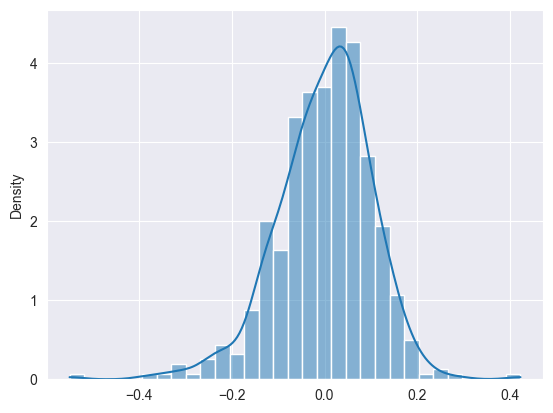

In [252]:
sns.histplot(res, kde=True, stat="density")

## 10. Prediction and Evaluation

### 10.1 Applying scaling on the test dataset

In [253]:
num_vars = ['yr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,mon,sat,sun,thu,tue,wed,light_snow_or_rain,mist_or_light_clouds
184,0.0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1.0,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,0,1,0,0,0,0
299,0.0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,1,0,0,1,0,0,0,0,0,1
221,0.0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0.0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,1,0,0,0,0,0,0


In [254]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,mon,sat,sun,thu,tue,wed,light_snow_or_rain,mist_or_light_clouds
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [255]:
y_test = df_test.pop('cnt')
X_test = df_test

In [256]:
final_cols = X_train_new.columns

X_test = X_test[final_cols]

# Adding constant variable to test dataframe
X_test_lm = sm.add_constant(X_test)

### 10.2 Predicting y_test

In [257]:
y_test_pred = lm.predict(X_test_lm)

### 10.3 $ {R^2} $ for test set

In [258]:
r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
round(r2, 3)

0.779

### 10.4 $ R^2_{adj} $ for test set

In [259]:
adjusted_r2 = round(1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1),4)
round(adjusted_r2, 3)

0.767

### 10.5 Plotting y_test and y_pred to understand the spread

Text(0, 0.5, 'y_test_pred')

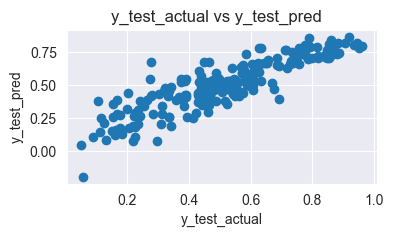

In [260]:
plt.figure(figsize = (4, 2))
plt.scatter(y_test, y_test_pred)
plt.suptitle('y_test_actual vs y_test_pred', fontsize = 12)
plt.xlabel('y_test_actual', fontsize = 10)
plt.ylabel('y_test_pred', fontsize = 10) 

### 10.6 Best Fit line coefficients

In [261]:
round(lm.params,4)

const                   0.5834
yr                      0.2459
holiday                -0.0854
windspeed              -0.1910
spring                 -0.2367
summer                 -0.0374
dec                    -0.1166
jan                    -0.1216
nov                    -0.1101
sep                     0.0607
light_snow_or_rain     -0.3155
mist_or_light_clouds   -0.0872
dtype: float64

### 10.7 The equation of our best fitted line

$$ 
cnt = 0.5834 + 0.2459  \times  yr - 0.0854  \times  holiday - 0.1910 \times windspeed - 0.2367 \times spring - 0.0374 \times summer 
    - 0.1166 \times dec - 0.1216 \times jan - 0.1101 \times nov + 0.0607 \times sep - 0.3155 \times light_snow_or_rain 
    - 0.0872 \times mist_or_light_clouds
$$

### 10.8 Visualizing the fit on the test data

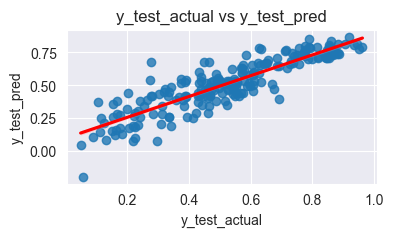

In [262]:
plt.figure(figsize = (4, 2))
sns.regplot(x=y_test, y=y_test_pred, ci=68, fit_reg=True, line_kws={"color": "red"})
plt.title('y_test_actual vs y_test_pred', fontsize=12)
plt.xlabel('y_test_actual', fontsize=10)
plt.ylabel('y_test_pred', fontsize=10)
plt.show()

### Comparison between Train and Test dataset:

| Dataset         |    $ {R^2} $    |  $ R^2_{adj} $  |
|:----------------|:---------------:|:---------------:|
| __Train__       |      0.791      |      0.786      |
| __Test__        |      0.779      |      0.767      |

## Conclusion:
### Bike rental count is depending on the following factors
- #### `yr`: Bookings increased from 2018 to 2019. With gain in popularity the bookings can further be increased.
- #### `holiday`: Holidays have negative impact on the bookings.
- #### `windspeed`: Wind speed is having negative impact on the bookings.
- #### `spring`: It is negatively related to booking count.
- #### `summer`: It is negatively related to booking count.
- #### `dec`: Fewer bookings happen in December.
- #### `jan`: Fewer bookings happen in January.
- #### `nov`: Fewer bookings happen in November.
- #### `sep`: More bookings happen in this month.
- #### `light_snow_or_rain`: Bookings are less in snowy or rainy days.
- #### `mist_or_light_clouds`: Bookings are less in misty or cloudy days.